In [1]:
import anndata
import gc
import scanpy as sc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [2]:
expr_path = '/data/scRNA/ABCA/AIBS/AWS/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-raw-wmeta.h5ad'
adata = sc.read_h5ad(expr_path)
adata

AnnData object with n_obs × n_vars = 3938808 × 550
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'

**Load modules dataframe**

In [3]:
modules_df = pd.read_csv(
    "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/WMB-10Xv3/20230630/outputs/WMB-10Xv3-CTXsp-sc-wgcna-modules.csv",
    index_col = "Unnamed: 0")
modules_df.head()

gene_name     module      color  kME_grey  \
ENSMUSG00000026712  ENSMUSG00000026712       blue       blue -0.021587   
ENSMUSG00000029361  ENSMUSG00000029361  turquoise  turquoise -0.254720   
ENSMUSG00000038173  ENSMUSG00000038173     yellow     yellow -0.068901   
ENSMUSG00000029648  ENSMUSG00000029648      brown      brown -0.093548   
ENSMUSG00000044288  ENSMUSG00000044288  turquoise  turquoise -0.317560   

                    kME_blue  kME_turquoise  kME_yellow  kME_brown   kME_red  \
ENSMUSG00000026712  0.190045      -0.073800   -0.024639  -0.003026  0.004748   
ENSMUSG00000029361 -0.111406       0.376375   -0.127625  -0.076101 -0.052044   
ENSMUSG00000038173 -0.043119      -0.139840    0.374000  -0.037253 -0.026067   
ENSMUSG00000029648  0.025604      -0.188880   -0.037207   0.969976  0.117885   
ENSMUSG00000044288 -0.161925       0.528835   -0.169507  -0.120401 -0.071409   

                    kME_green  
ENSMUSG00000026712  -0.038685  
ENSMUSG00000029361  -0.089421  
ENSMUSG00000038173   0.081146  
ENSMUSG00000029648  -0.119514  
ENSMUSG00000044288  -0.069976

Steps to get Module Eigengenes for MERFISH cells:
- Select genes for each module
- Select cells for the brain region
- Process the gene expression data
- Compute PC1
- Visualize

In [23]:
select_module = "yellow"
select_genes = modules_df[modules_df["module"] == select_module].index
common_genes = adata.var_names.intersection(select_genes)
adata_subset = adata[:,common_genes]
adata_subset

View of AnnData object with n_obs × n_vars = 3938808 × 15
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'

In [24]:
sc.pp.filter_cells(adata_subset, min_genes=5)
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
sc.pp.scale(adata_subset, max_value=10)
sc.tl.pca(adata_subset, n_comps = 2, svd_solver="arpack")
adata_subset

/home/momo/miniforge3/envs/abca-env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


AnnData object with n_obs × n_vars = 1828439 × 15
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'n_genes'
    var: 'gene_symbol', 'transcript_identifier', 'mean', 'std'
    uns: 'accessed_on', 'src', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
def plot_pca(xx, yy, cc=None, val=None, adata=None, pc_component=None, 
                 fig_width=8, fig_height=8, cmap=None, cbar_label=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    scatter_plot = None  # To hold the scatter plot object
    
    # PCA component coloring
    if pc_component is not None:
        if adata is None:
            raise ValueError("adata must be provided when using pc_component.")
        val = adata.obsm['X_pca'][:, pc_component]
        cmap = cmap or 'viridis'
        scatter_plot = ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
        cbar_label = cbar_label or f'PC{pc_component + 1}'  # Auto-label for PCA
        
    # Regular colormap coloring
    elif cmap is not None:
        scatter_plot = ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
        cbar_label = cbar_label or 'Value'  # Default label
        
    # Categorical color list
    elif cc is not None:
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    # Default to black
    else:
        ax.scatter(xx, yy, s=0.5, color='k', marker='.')
    
    # Add color bar if needed
    if scatter_plot is not None:
        cbar = fig.colorbar(scatter_plot, ax=ax, shrink=0.6, aspect=10)
        if cbar_label:
            cbar.set_label(cbar_label, rotation=270, labelpad=15)
    
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

In [26]:
adata_section = adata_subset[adata_subset.obs['brain_section_label'] == 'C57BL6J-638850.38']
adata_section

View of AnnData object with n_obs × n_vars = 68354 × 15
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'n_genes'
    var: 'gene_symbol', 'transcript_identifier', 'mean', 'std'
    uns: 'accessed_on', 'src', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

(<Figure size 800x800 with 2 Axes>, <Axes: >)

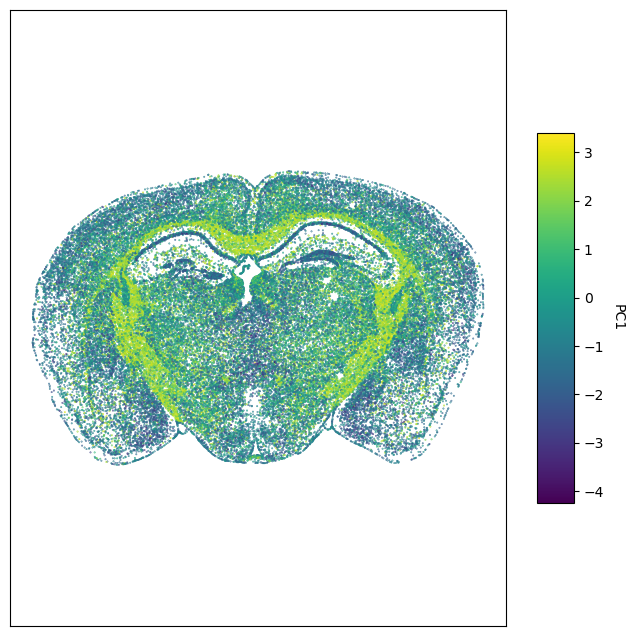

In [27]:
plot_pca(adata_section.obs['x'], adata_section.obs['y'], adata=adata_section, pc_component=0, cmap='viridis')

## Plot cell labels

In [29]:
# Updated Plot function to include Legends

from matplotlib.lines import Line2D
def plot_umap(xx, yy, cc=None, val=None, label_column=None, fig_width=8, fig_height=8, cmap=None):
    # Initialize plot with constrained layout to prevent overlap
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(fig_width, fig_height)
    
    # Plot the data
    if cmap is not None:
        scatter = ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        scatter = ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
    else:
        scatter = ax.scatter(xx, yy, s=0.5, marker='.')
    
    # Set axis properties dynamically based on data
    ax.set_ylim(yy.max() + 0.5, yy.min() - 0.5)  # Add small padding to y-axis
    ax.set_xlim(xx.min() - 0.5, xx.max() + 0.5)  # Add small padding to x-axis
    ax.axis('equal')  # Ensure equal scaling
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add legend if label_column is provided
    if label_column is not None:
        # Create DataFrame for unique label-color pairs
        df_legend = pd.DataFrame({'label': label_column, 'color': cc}).drop_duplicates().sort_values('label')
        
        # Create legend handles
        legend_elements = [
            Line2D([0], [0], 
                   marker='o', 
                   color='w', 
                   label=row['label'],
                   markerfacecolor=row['color'], 
                   markersize=8)
            for _, row in df_legend.iterrows()
        ]
        
        # Add legend outside the plot (adjust bbox_to_anchor as needed)
        ax.legend(
            handles=legend_elements, 
            title="Legend", 
            loc="upper left",  # Anchor point for the legend
            bbox_to_anchor=(1.05, 1)  # Shift legend to the right of the plot
        )
    
    return fig, ax

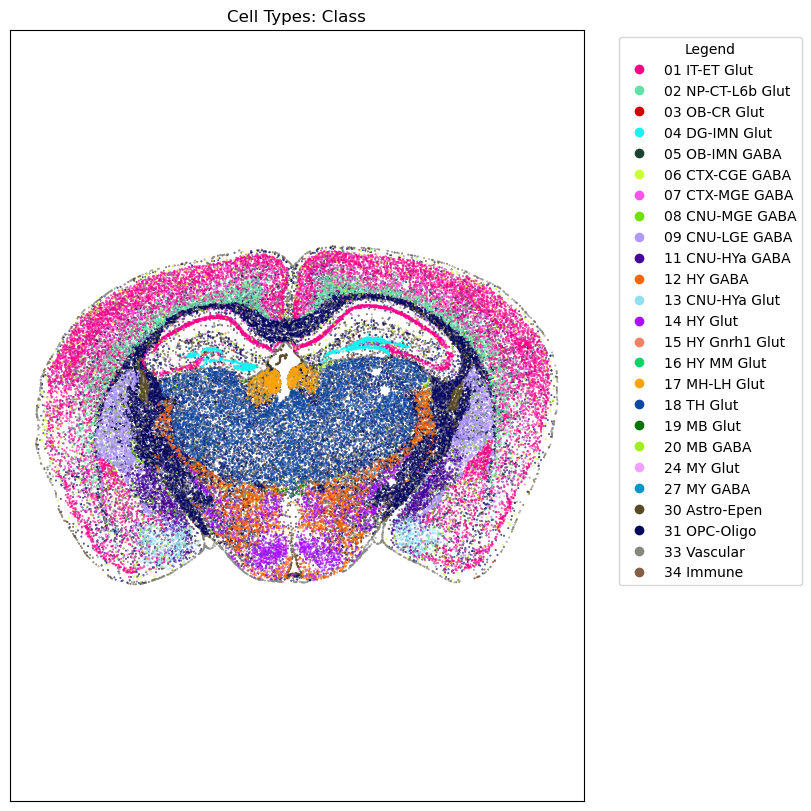

In [30]:
fig, ax = plot_umap(adata_section.obs['x'],\
    adata_section.obs['y'],
    cc = adata_section.obs['class_color'],
    label_column = adata_section.obs['class'])
res = ax.set_title("Cell Types: Class")
plt.show()

In [ ]:
# Simple function to plot UMAP
def plot_section(xx, yy, cc = None, val = None, fig_width = 8, fig_height = 8, cmap = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

In [ ]:
pred = (adata.obs['brain_section_label'] == 'C57BL6J-638850.38')
section = adata.obs[pred]
print("Number of cells in section:",len(section))

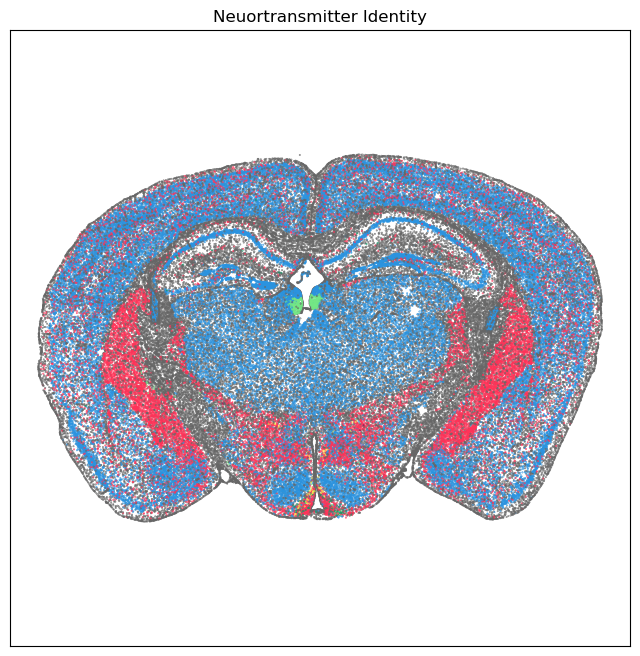

In [17]:
fig, ax = plot_section(section['x'], section['y'], section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")
plt.show()

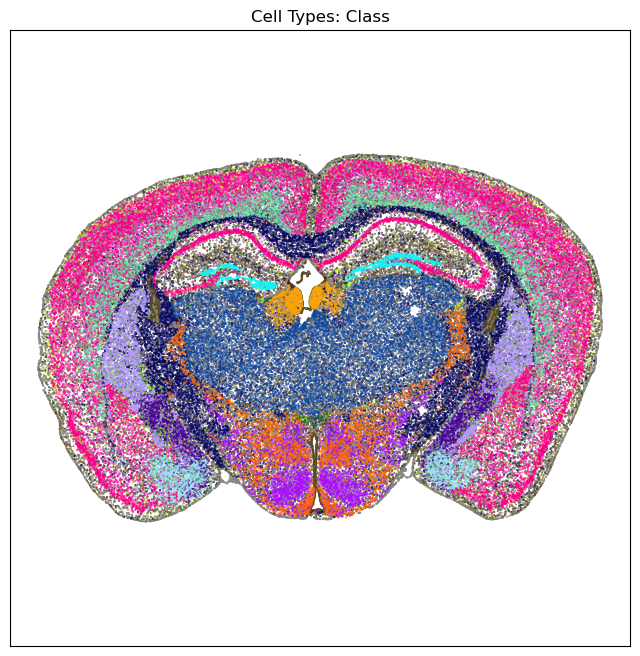

In [9]:
fig, ax = plot_section(section['x'], section['y'], section['class_color'])
res = ax.set_title("Cell Types: Class")
plt.show()

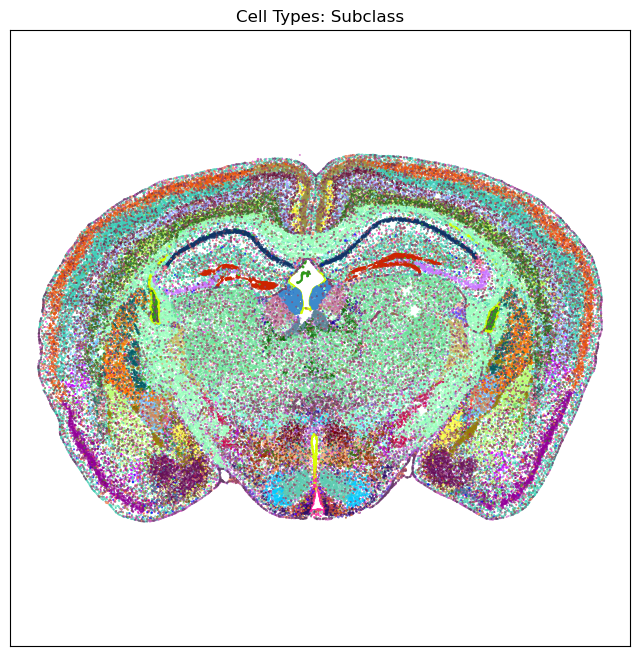

In [10]:
fig, ax = plot_section(section['x'], section['y'], section['subclass_color'])
res = ax.set_title("Cell Types: Subclass")
plt.show()

## Plot expressions

In [11]:
def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap = plt.cm.magma_r):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=5)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

In [14]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

gene_symbol transcript_identifier
gene_identifier                                     
ENSMUSG00000030500     Slc17a6    ENSMUST00000032710
ENSMUSG00000037771     Slc32a1    ENSMUST00000045738
ENSMUSG00000025400        Tac2    ENSMUST00000026466
ENSMUSG00000039728      Slc6a5    ENSMUST00000056442
ENSMUSG00000070570     Slc17a7    ENSMUST00000085374
ENSMUSG00000019935     Slc17a8    ENSMUST00000020102
ENSMUSG00000021609      Slc6a3    ENSMUST00000022100
ENSMUSG00000020838      Slc6a4    ENSMUST00000021195

In [18]:
asubset = adata[:, gene_filtered.index].to_memory()

In [19]:
def create_expression_dataframe(ad, gf):
    gdata = ad[:, gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = section.join(gdata)
    return joined

def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

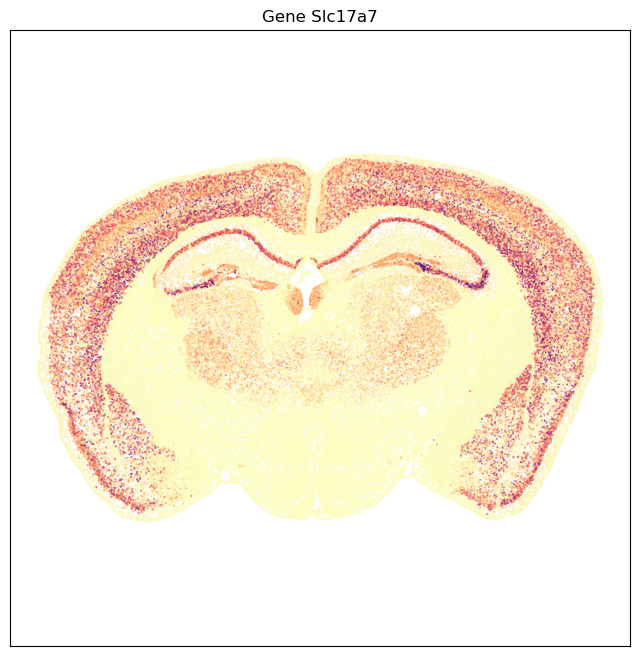

In [21]:
fig, ax = plot_section(ntexp['x'], ntexp['y'], val=ntexp['Slc17a7'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Slc17a7')
plt.show()

/tmp/ipykernel_42838/1180391112.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(value)[gnames].mean()


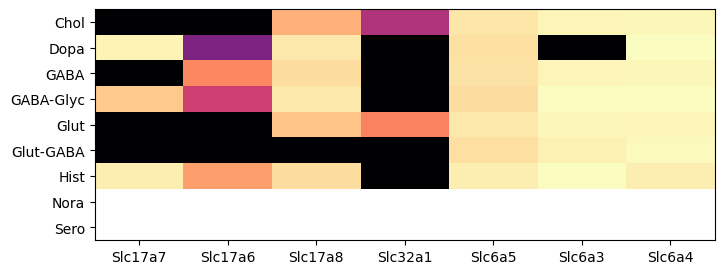

In [20]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe(asubset, gf)
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg = agg[ntgenes]
im = plot_heatmap(agg, 8, 3)
plt.show()

## Plot expression over Z

In [7]:
def plot_sections(df, feature, blist, cmap = None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist):
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0, 11)
        ax[idx].set_ylim(11, 0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl))
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

In [ ]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
filtered = exp[ntgenes]
joined = cell.join(filtered)

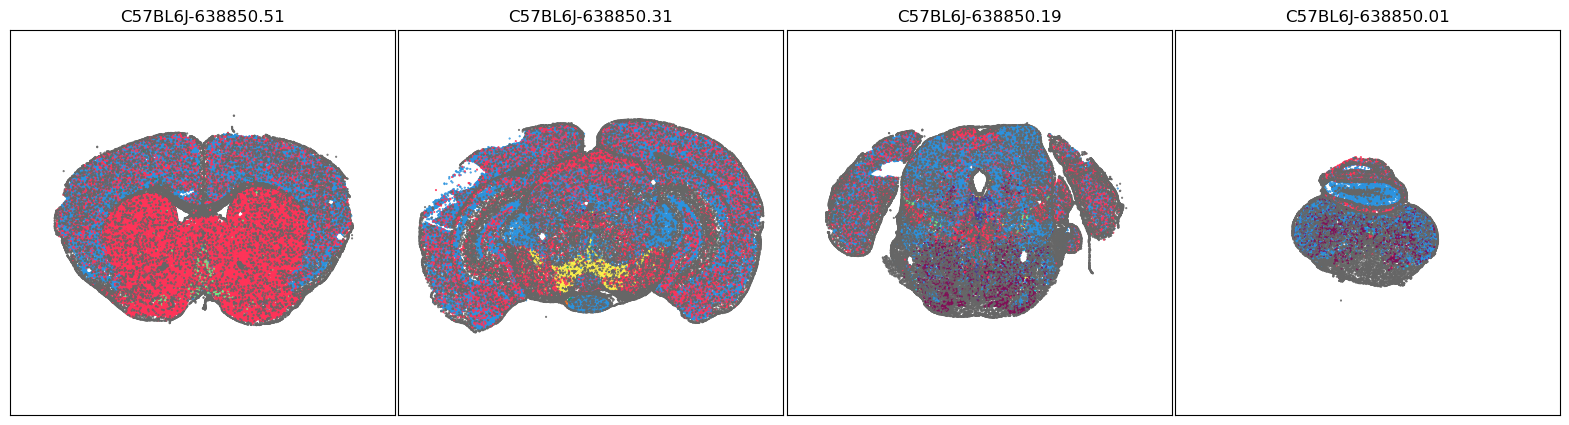

In [9]:
blist = ['C57BL6J-638850.51', 'C57BL6J-638850.31', 'C57BL6J-638850.19', 'C57BL6J-638850.01']
fig, ax = plot_sections(adata.obs, 'neurotransmitter_color', blist, cmap=None)
plt.show()

In [22]:
del adata, asubset
gc.collect()

6531